In [3]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Dense
from tensorflow.keras.optimizers import Adam

from skimage.metrics import structural_similarity as ssim



In [4]:
(x_train,_),(x_test,_) = fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [5]:
#veri normalizasyon
x_train = x_train.astype('float32')/255.0
x_test = x_test.astype('float32')/255.0

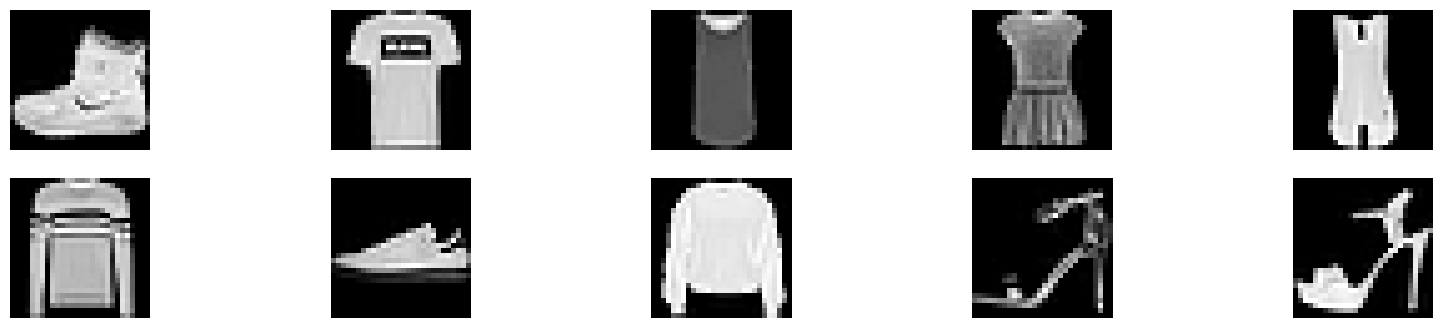

In [6]:
# görselleştirme
plt.figure(figsize=(20,4))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(x_train[i],cmap='gray')
    plt.axis('off')

In [7]:
# veriyi düzleştir: 28x28 boyutundaki görüntüleri 784 boyutuna bir vektöre çevir
x_train = x_train.reshape((len(x_train),np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test),np.prod(x_test.shape[1:])))

In [9]:
# autoencoders için model parametrelerinin tanımlanması
input_dim = x_train.shape[1] # giriş boyutu (784)
encoding_dim = 64 # latent boyutu (daha küçük boyut)

In [11]:
# encoder kısmının inşa edilmesi
input_image = Input(shape=(input_dim,)) #girdi boyutunu belirledik (784)
encoded = Dense(256,activation='relu')(input_image) #ilk gizli katman (256 nöron)
encoded = Dense(128,activation='relu')(encoded)#ikinci gizli katman (128 nöron)
encoded = Dense(encoding_dim,activation='relu')(encoded)#sıkıştırma katmanı (64 boyut)

In [12]:
# decoder kısmının inşası
decoded = Dense(128,activation='relu')(encoded)#ilk genişletme katmanı
decoded = Dense(256,activation='relu')(decoded)#ikinci genişletme katmanı
decoded = Dense(input_dim,activation='sigmoid')(decoded)#çıkış katmanı (784 boyutlu)

In [14]:
#autoencoders oluşturma = encoder + decoder
autoencoder = Model(input_image,decoded) # girişten çıkışa tüm yapıyı tanımlıyoruz

In [15]:
# modelin compile edilmesi
autoencoder.compile(optimizer=Adam(),loss='binary_crossentropy')

In [16]:
# modelin train edilmesi
autoencoder.fit(
    x_train,x_train,# geridi ve hedef aynı değer olmalı (otonom öğrenme)
    epochs=50,
    batch_size=256,
    shuffle=True,#eğitim verilerini karıştırır
    validation_data=(x_test,x_test),
    verbose=1)

Epoch 1/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - loss: 0.4345 - val_loss: 0.3119
Epoch 2/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - loss: 0.3049 - val_loss: 0.2980
Epoch 3/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - loss: 0.2951 - val_loss: 0.2930
Epoch 4/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.2898 - val_loss: 0.2899
Epoch 5/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - loss: 0.2859 - val_loss: 0.2868
Epoch 6/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - loss: 0.2829 - val_loss: 0.2839
Epoch 7/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.2815 - val_loss: 0.2822
Epoch 8/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - loss: 0.2795 - val_loss: 0.2819
Epoch 9/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - loss: 0.2784 - val_loss: 0.2800
Epoch 10/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.2767 - val_loss: 0.2782
Epoch 11/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.2750 - val_loss: 0.2774
Epoch 12/50
235/235 ━━━━━━━━━━━━━━━━━━

In [17]:
# modeli encder ve decoder olarak ikiye ayır
encoder = Model(input_image,encoded)

# decoder
encoded_input = Input(shape=(encoding_dim,))
decoder_layer1 = autoencoder.layers[-3](encoded_input)
decoder_layer2 = autoencoder.layers[-2](decoder_layer1)
decoder_output = autoencoder.layers[-1](decoder_layer2)

decoder = Model(encoded_input,decoder_output)

In [18]:
# test verisi ile encoder ve ddecoder ile sıkıştırma ve yeniden yapılandırma işlemi
encoded_images = encoder.predict(x_test) # latent temsili elde ederiz
decoded_images = decoder.predict(encoded_images)# latent temsillerini orijinal forma geri çevir

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


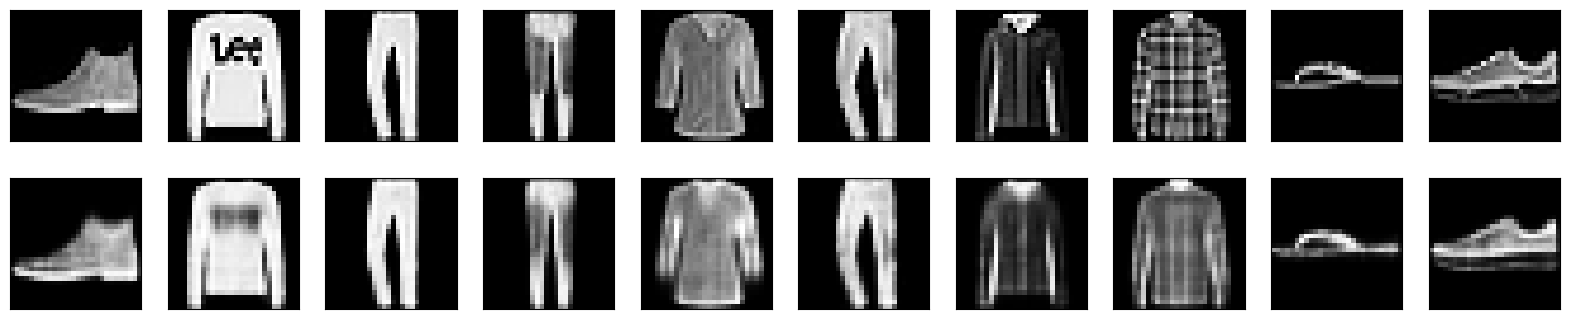

In [19]:
# orijinal ve yeniden yapılandırılmış (decoded_images) görüntüleri görselleştir
n = 10 # 10 sample

plt.figure(figsize=(20,4))
for i in range(n):
  #orjinal görüntü
  ax = plt.subplot(2,n,i+1)
  plt.imshow(x_test[i].reshape(28,28),cmap='gray') # orijinal görünüt boyutuna ceviriyoruz
  ax.get_xaxis().set_visible(False)# x eksenini gizledik
  ax.get_yaxis().set_visible(False)# y eksenini gizledik

  # yeniden yapılandırılmış görüntü
  ax = plt.subplot(2,n,i+1+n)
  plt.imshow(decoded_images[i].reshape(28,28),cmap='gray')
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()

In [20]:
# ssmi skorlarını hesapla
def compute_ssim(orijinal,reconstructed):
  """
  her iki görüntü arasında ssim skoru (0-1) hesapla
  """
  orijinal = orijinal.reshape(28,28)
  reconstructed = reconstructed.reshape(28,28)
  return ssim(orijinal,reconstructed,data_range=1)

In [21]:
# test ver iseti için ssim hesapla
ssim_scores = []

# ilk 100 tanesini hesapla
for i in range(100):

  original_img = x_test[i]
  reconstructed_img = decoded_images[i]

  score = compute_ssim(original_img,reconstructed_img)
  ssim_scores.append(score)

average_ssim = np.mean(ssim_scores)
print(f"Ortalama SSIM skoru: {average_ssim}")

Ortalama SSIM skoru: 0.8234002633127634
